In [3]:
from datetime import datetime 
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units, pandas_dataframe_to_unit_arrays
import matplotlib.pyplot as plt
import metpy.plots as plots
import metpy.calc as mpcalc
import numpy as np
from matplotlib.pyplot import imread

%matplotlib inline

In [22]:
date = datetime(2021, 7, 19, 12) #sept-10-2017 @ 0000z
station = '78486'

df = WyomingUpperAir.request_data(date, station)
d  = pandas_dataframe_to_unit_arrays(df)

mandatory_levels = [1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100]

# p = d['pressure']
# t = d['temperature']
# td = d['dewpoint']
# u = d['u_wind']
# v = d['v_wind']
# h = d['height']

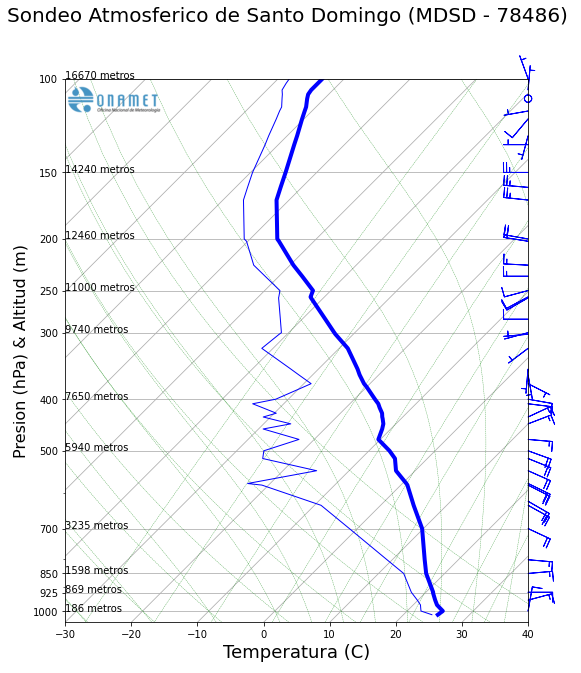

In [23]:
fig = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig, rotation = 45)

skew.plot(d['pressure'], d['temperature'], 'b', linewidth = 4)
skew.plot(d['pressure'], d['dewpoint'], 'b', linewidth = 1)

skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-30, 40)

fig.suptitle('Sondeo Atmosferico de Santo Domingo (MDSD - 78486)', fontsize = 20)
plt.xlabel('Temperatura (C)', fontsize = 18)
plt.ylabel('Presion (hPa) & Altitud (m)', fontsize = 16)
plt.yticks(ticks=mandatory_levels)

interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(d['pressure'], interval)
skew.plot_barbs(d['pressure'][idx], d['u_wind'][idx], d['v_wind'][idx], barbcolor = 'blue', sizes = 
               dict(width = 0.01))

skew.plot_dry_adiabats(colors = 'green', linewidth = 0.4, alpha = 0.7)
skew.plot_moist_adiabats(colors = 'green', linewidth = 0.4, alpha = 0.7)

p_space = np.linspace(100, max(skew.ax.get_ylim())) * units.mbar
skew.plot_mixing_lines(pressure = p_space, colors = 'green', linewidth = 0.4, alpha = 0.7)
#skew.plot_mixing_lines(colors = 'green', linewidth = 0.4, alpha = 0.7)

logo = imread('onamet_75x75.png')
fig.figimage(logo, 65, 560, zorder=100)

#interval = [k for k in range(1000, 0, -100)] * units.hPa
interval = mandatory_levels * units.hPa
idx = mpcalc.resample_nn_1d(d['pressure'], interval)
for p, t, h  in zip(d['pressure'][idx], d['temperature'][idx], d['height'][idx]):
    if p >= 100 * units.hPa:
        skew.ax.text(-0.0001, p, f'{round(h.m, 0)} metros', fontsize=10, 
                     transform = skew.ax.get_yaxis_transform(which='tick2'))

In [4]:
# # skew.ax.axhline(lcl_pressure)

# skew.ax.set_facecolor('lightblue')
# fig.patch.set_color('bisque')


# skew.ax.axvline(x=0, ymin=0, ymax=0.28, color='c', linestyle='--', linewidth=2)
# lcl_pressure, lcl_temperature = mpcalc.lcl(d['pressure'][0], d['temperature'][0], d['dewpoint'][0])
# skew.plot(lcl_pressure, lcl_temperature, color = 'black', marker = 'o', markerfacecolor='red')

In [9]:
#https://stackoverflow.com/questions/65985185/cape-cin-returning-incorrect-values

# Calculate the mixed parcel--need to pass pressure as an additional variable to "mix" so that we get
# an appropriate "average pressure" to use as the mixed parcel

parcel_temperature, parcel_dewpoint, mixed_pressure = mpcalc.mixed_layer(d['pressure'], d['temperature'],
                                                           d['dewpoint'], d['pressure'],
                                                           height=d['height'], depth=500 * units.m)

# Replace the lowest part of the sounding with the mixed value
pressure_mixed = np.concatenate([np.atleast_1d(mixed_pressure), d['pressure'][d['pressure'] < mixed_pressure]])
temperature_mixed = np.concatenate([np.atleast_1d(parcel_temperature), 
                                    d['temperature'][d['pressure'] < mixed_pressure]])
dewpoint_mixed = np.concatenate([np.atleast_1d(parcel_dewpoint), d['dewpoint'][d['pressure'] < mixed_pressure]])

# Calculate the parcel profile, including the LCL--this interpolates the sounding to the level of the LCL
# as well, so that the profile and all variables have the same points

parcel_path_LCL = mpcalc.parcel_profile(pressure_mixed, parcel_temperature, parcel_dewpoint)
skew.plot(pressure_mixed, parcel_path_LCL, color = 'k', linewidth = 0.4)

mask = pressure_mixed >= 200 * units.hPa
skew.shade_cape(pressure_mixed, temperature_mixed, parcel_path_LCL)
skew.shade_cin(pressure_mixed[mask], temperature_mixed[mask], parcel_path_LCL[mask])



In [5]:
lcl_pressure, lcl_temperature = mpcalc.lcl(mixed_pressure, parcel_temperature, parcel_dewpoint)
lfc_pressure, lfc_temperature = mpcalc.lfc(pressure_mixed, temperature_mixed, dewpoint_mixed)
el_pressure, el_temperature = mpcalc.el(pressure_mixed, temperature_mixed, dewpoint_mixed)

cape, cin = mpcalc.cape_cin(pressure_mixed, temperature_mixed, dewpoint_mixed, parcel_path_LCL)

li = mpcalc.lifted_index(pressure_mixed, temperature_mixed, parcel_path_LCL)

pw = mpcalc.precipitable_water(d['pressure'], d['dewpoint'])



In [6]:
idx = np.where(d['pressure'] == 850 * units.hPa)
idx = idx[0][0]
T850 = d['temperature'][idx]
TD850 = d['dewpoint'][idx]
WS850 = d['speed'][idx]
WD850 = d['speed'][idx]
pressure_set_from_850  = d['pressure'][idx:]
parcel_path_850 = mpcalc.parcel_profile(pressure_set_from_850, d['temperature'][idx], d['dewpoint'][idx])

idx = np.where(d['pressure'] == 500 * units.hPa)
idx = idx[0][0]
T500 = d['temperature'][idx]
Tp500 = parcel_path_LCL[idx].to(units.degC)
WS500 = d['speed'][idx]
WD500 = d['speed'][idx]


idx = np.where(d['pressure'] == 700 * units.hPa)
idx = idx[0][0]
T700 = d['temperature'][idx]
TD700 = d['dewpoint'][idx]

idx = np.where(pressure_set_from_850 == 500 * units.hPa)
idx = idx[0][0]
Tp500_850 = parcel_path_850[idx].to(units.degC)


KINX = ( T850 - T500 ) + TD850 - ( T700 - TD700 ) 
CTOT = TD850 - T500 
VTOT = T850 - T500 
TOTL = ( T850 - T500 ) + ( TD850 - T500 )
SHOW = T500 - Tp500_850


#######SWET = 12 * TD850 + 20 * TERM2 + 2 * SKT850 + SKT500 + SHEAR 
a = 0
WD_500_850 = WD500.m - WD850.m
if 130 <= WD850.m <= 250 and 210 <= WD500.m <= 310 and  WD_500_850 > 0 and WS500.m >= 15 and WS850.m >= 15:
    a = 1
    
b=0
if TOTL.m > 49:
    b = 1
    
SWET = 12*TD850.m + 20 * b * TOTL.m + 2*WS850.m + WS500.m + 125 * a *(float(np.sin(WD500.m - WD850.m)) + 0.2)


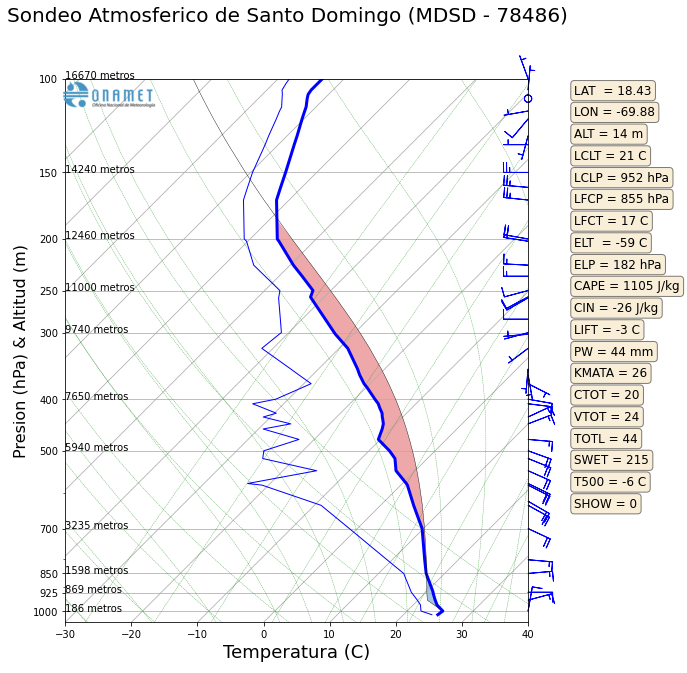

In [7]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

txts     = [f'LAT  = 18.43', f'LON = -69.88', f'ALT = 14 m',            
            f'LCLT = {int(lcl_temperature.m)} C', f'LCLP = {int(lcl_pressure.m)} hPa', 
            f'LFCP = {int(lfc_pressure.m)} hPa', f'LFCT = {int(lfc_temperature.m)} C', 
            f'ELT  = {int(el_temperature.m)} C', f'ELP = {int(el_pressure.m)} hPa',
            f'CAPE = {int(cape.m)} J/kg', f'CIN = {int(cin.m)} J/kg',
            f'LIFT = {int(li.m)} C', f'PW = {int(pw.m)} mm', f'KMATA = {int(KINX.m)}',
            f'CTOT = {int(CTOT.m)}', f'VTOT = {int(VTOT.m)}', f'TOTL = {int(TOTL.m)}',
            f'SWET = {int(SWET)}', f'T500 = {int(T500.m)} C', f'SHOW = {int(SHOW.m)}']

xtxt = 1.1
ytxt = 0.99

for txt in txts:
    skew.ax.text(xtxt, ytxt, txt, transform=skew.ax.transAxes, fontsize=12,
                 verticalalignment='top', bbox=props)
    ytxt = ytxt - 0.04
fig